In [50]:
import nltk
from nltk.corpus import reuters
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

In [34]:
train_documents, train_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('training/')])
test_documents, test_categories = zip(*[(reuters.raw(i), reuters.categories(i)) for i in reuters.fileids() if i.startswith('test/')])

In [35]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [39]:
tfidfvectorizer = TfidfVectorizer(tokenizer = tokenize, stop_words = 'english')
tfidf_vectorised_train_documents = tfidfvectorizer.fit_transform(train_documents)
tfidf_vectorised_test_documents = tfidfvectorizer.transform(test_documents)

In [40]:
train_documents[0], tfidf_vectorised_train_documents[0].toarray()

('BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry period means the temporao will be late this year.\n      Arrivals for the week ended February 22 were 155,221 bags\n  of 60 kilos making a cumulative total for the season of 5.93\n  mln against 5.81 at the same stage last year. Again it seems\n  that cocoa delivered earlier on consignment was included in the\n  arrivals figures.\n      Comissaria Smith said there is still some doubt as to how\n  much old crop cocoa is still available as harvesting has\n  practically come to an end. With total Bahia crop estimates\n  around 6.4 mln bags and sales standing at almost 6.2 mln there\n  are a few hundred thousand bags still in the hands of farmers,\n  middlemen, exporters and processors.\n 

In [47]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)

(7769, 90)

In [53]:
tfidf_vectorised_train_documents.shape, train_labels.shape

((7769, 35658), (7769, 90))

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [59]:
train_features = torch.tensor(tfidf_vectorised_train_documents.todense())
train_labels = torch.tensor(train_labels)

test_features = torch.tensor(tfidf_vectorised_test_documents.todense())
test_labels = torch.tensor(test_labels)

In [62]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [73]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# define the architecture
class MultiLabelNetwork(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLabelNetwork, self).__init__()

        self.layer1 = nn.Linear(input_dim, 1024)
        self.layer2 = nn.Linear(1024, 1024)
        self.layer3 = nn.Linear(1024, 256)
        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # use sigmoid for multilabel
        return x

# instantiate the model
input_dim = 35658
num_classes = 90
model = MultiLabelNetwork(input_dim, num_classes).to(device)

# define a loss function and optimizer
criterion = nn.BCELoss()  # binary cross-entropy loss for multilabel
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10
# training loop
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    i=0
    # reset the tqdm bar
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for inputs, labels in tqdm_bar:  # assuming dataloader is defined
        i+=1
        batch_features, batch_labels = inputs.to(device), labels.to(device)
        batch_features, batch_labels = batch_features.float(), batch_labels.float()
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        tqdm_bar.set_postfix({'loss': loss.item()})

Epoch 1/10


Training Epoch 0 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 2/10


Training Epoch 1 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 3/10


Training Epoch 2 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 4/10


Training Epoch 3 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 5/10


Training Epoch 4 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 6/10


Training Epoch 5 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 7/10


Training Epoch 6 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 8/10


Training Epoch 7 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 9/10


Training Epoch 8 :   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 10/10


Training Epoch 9 :   0%|          | 0/243 [00:00<?, ?it/s]

In [17]:
%%time
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

classifier = OneVsRestClassifier(LinearSVC())
classifier.fit(vectorised_train_documents, train_labels)

CPU times: user 1.51 s, sys: 20 ms, total: 1.53 s
Wall time: 1.53 s


OneVsRestClassifier(estimator=LinearSVC())

In [18]:
%%time
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, random_state = 42, shuffle = True)
scores = cross_val_score(classifier, vectorised_train_documents, train_labels, cv = kf)

CPU times: user 12.7 s, sys: 195 ms, total: 12.9 s
Wall time: 12.9 s


In [19]:
print('Cross-validation scores:', scores)
print('Cross-validation accuracy: {:.4f} (+/- {:.4f})'.format(scores.mean(), scores.std() * 2))

Cross-validation scores: [0.83526384 0.86872587 0.80566281 0.83140283 0.83783784 0.81595882
 0.82754183 0.80566281 0.80566281 0.82860825]
Cross-validation accuracy: 0.8262 (+/- 0.0370)


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predictions = classifier.predict(vectorised_test_documents)

accuracy = accuracy_score(test_labels, predictions)

macro_precision = precision_score(test_labels, predictions, average='macro')
macro_recall = recall_score(test_labels, predictions, average='macro')
macro_f1 = f1_score(test_labels, predictions, average='macro')

micro_precision = precision_score(test_labels, predictions, average='micro')
micro_recall = recall_score(test_labels, predictions, average='micro')
micro_f1 = f1_score(test_labels, predictions, average='micro')

cm = confusion_matrix(test_labels.argmax(axis = 1), predictions.argmax(axis = 1))

In [21]:
print("Accuracy: {:.4f}\nPrecision:\n- Macro: {:.4f}\n- Micro: {:.4f}\nRecall:\n- Macro: {:.4f}\n- Micro: {:.4f}\nF1-measure:\n- Macro: {:.4f}\n- Micro: {:.4f}".format(accuracy, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))

Accuracy: 0.8099
Precision:
- Macro: 0.6074
- Micro: 0.9467
Recall:
- Macro: 0.3702
- Micro: 0.7970
F1-measure:
- Macro: 0.4405
- Micro: 0.8654


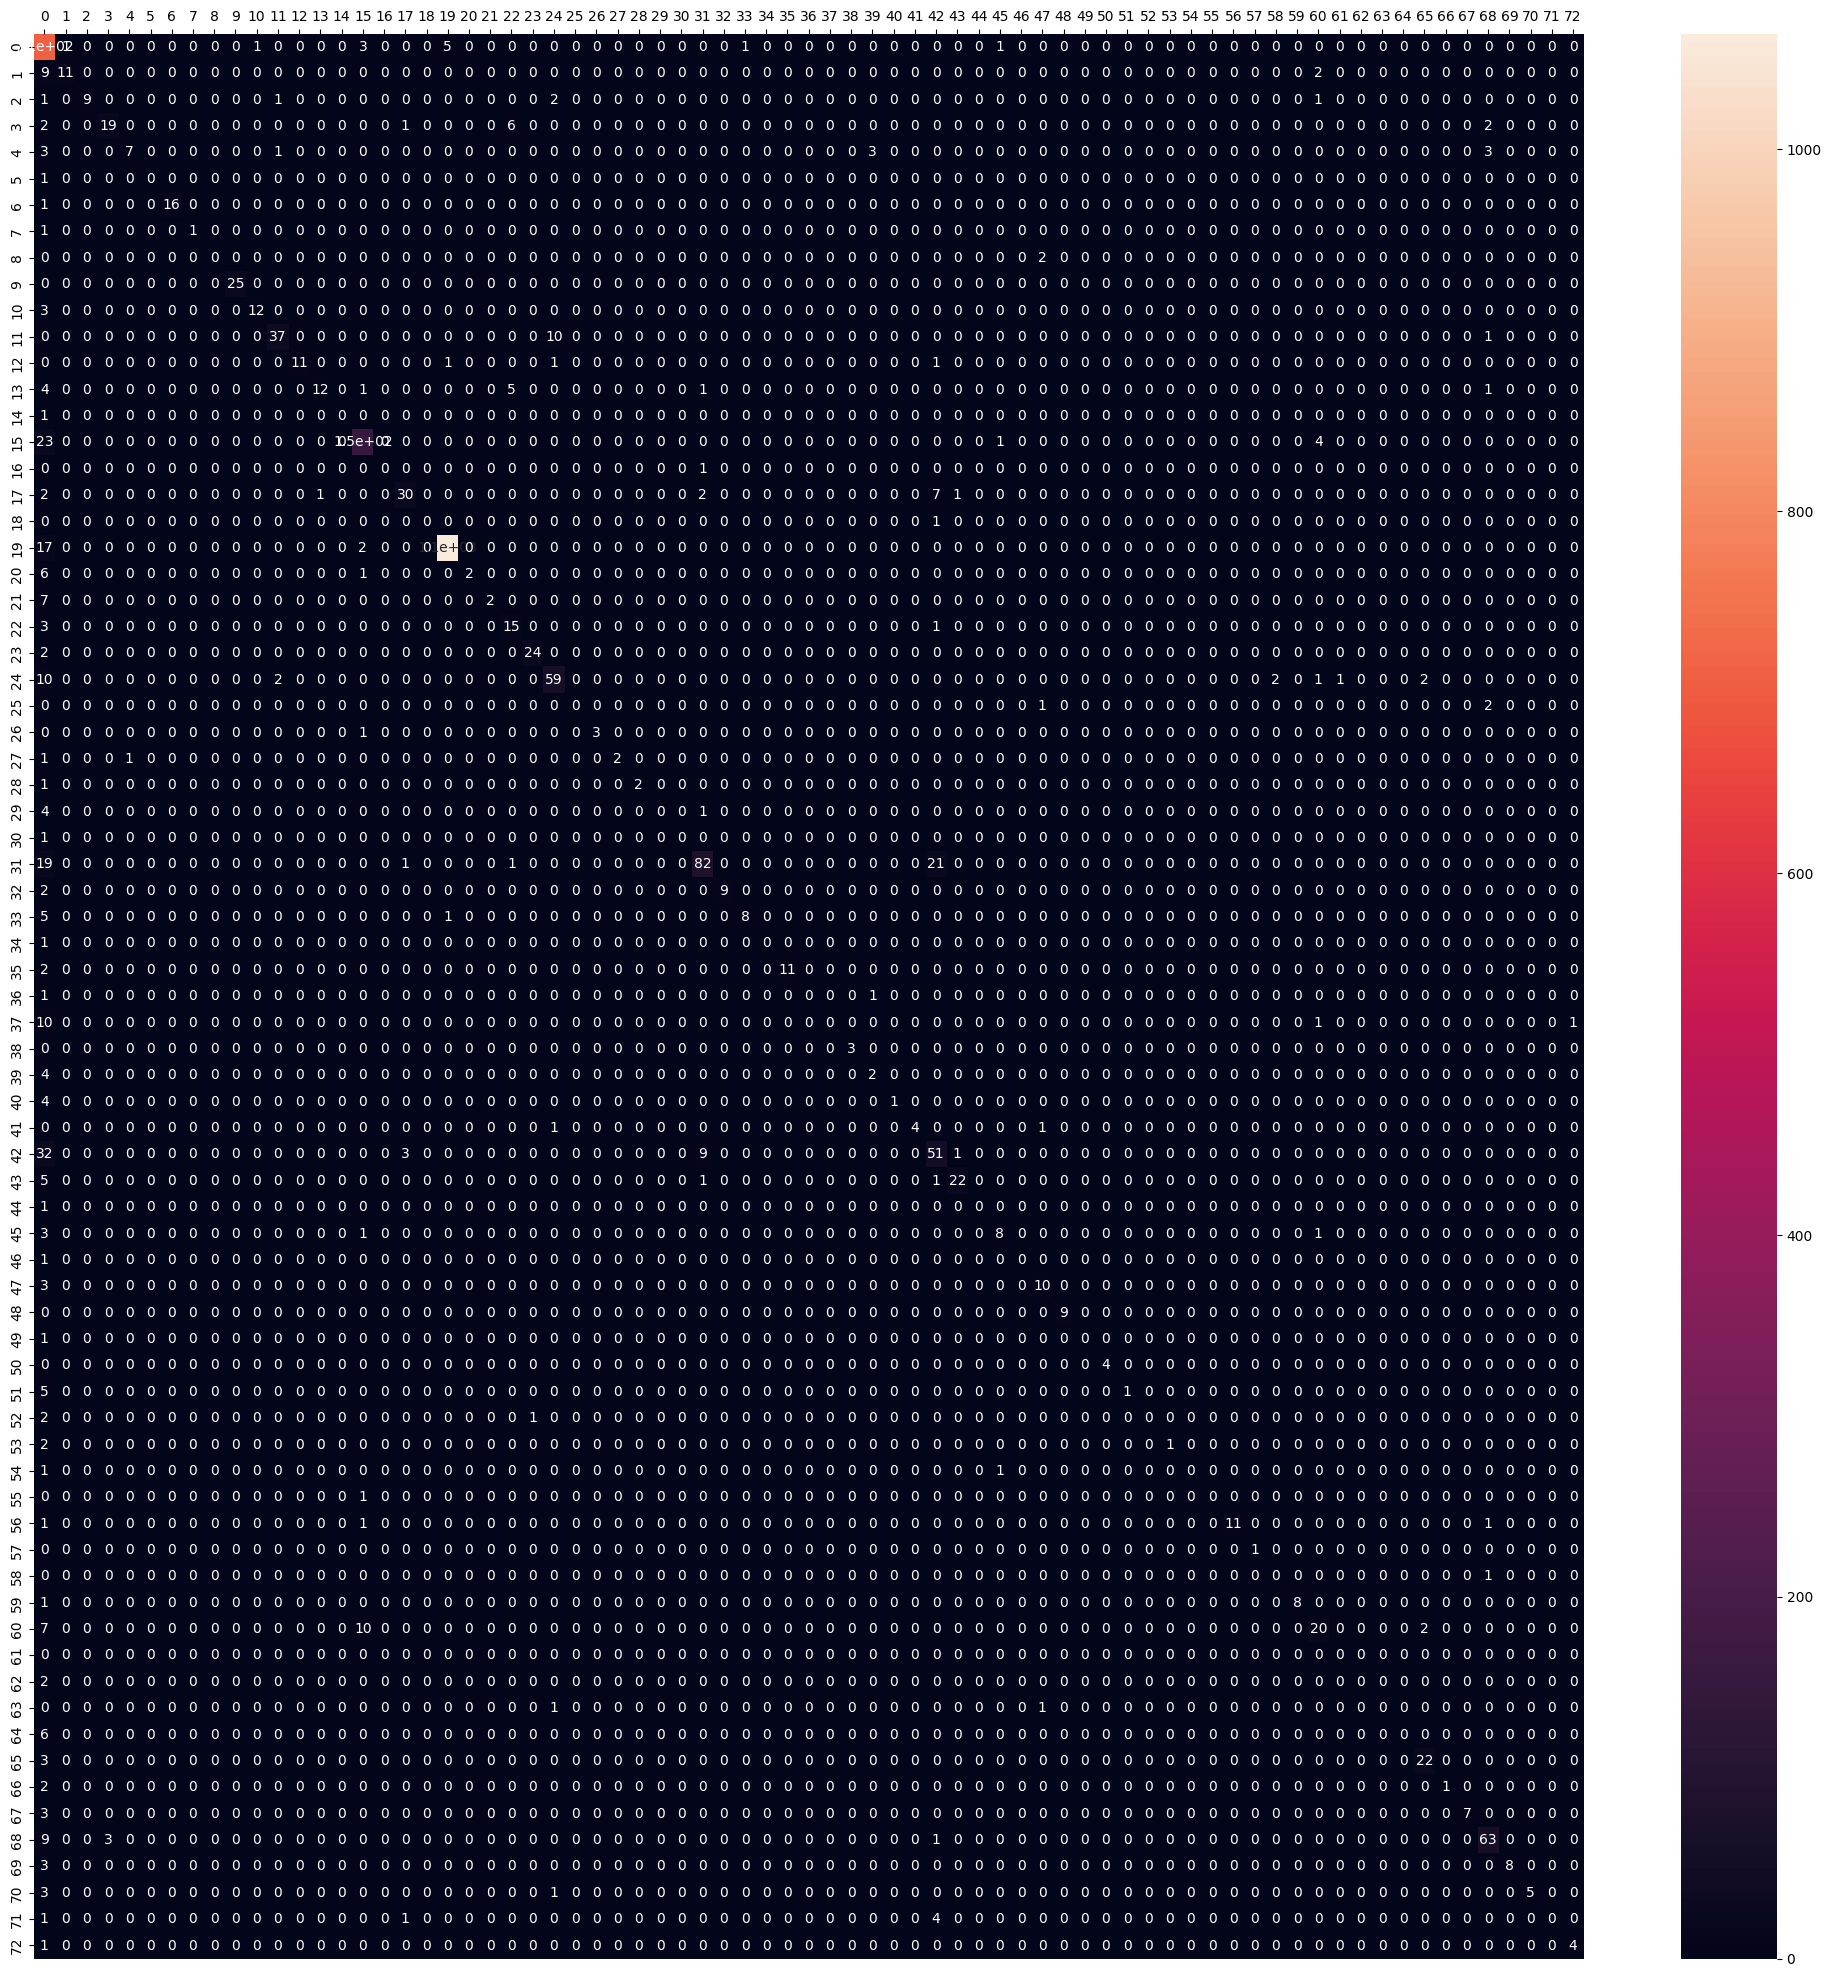

In [26]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

cm_plt = pd.DataFrame(cm[:73])

plt.figure(figsize = (25, 25))
ax = plt.axes()

sb.heatmap(cm_plt, annot=True)

ax.xaxis.set_ticks_position('top')

plt.show()

In [25]:
%pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 12.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
